In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from morpheus.classifier import Classifier
from morpheus.data import example
%matplotlib inline

# Getting Data H,J,V,z

In [43]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
f105w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits'))
f125w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f125w_v1_drz.fits'))
f140w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f140w_v1_drz.fits'))
f160w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits'))
h, j, v, z = f105w_nircam_i2d, f125w_nircam_i2d, f140w_nircam_i2d, f160w_nircam_i2d

hdat = fits.getdata(h, ext=0)
jdat = fits.getdata(j, ext=0)
vdat = fits.getdata(v, ext=0)
zdat = fits.getdata(z, ext=0)

h_header = fits.getheader(h, ext=0)
j_header = fits.getheader(j, ext=0)
v_header = fits.getheader(v, ext=0)
z_header = fits.getheader(z, ext=0)

# Image Show (Unncecessary Would Delete)

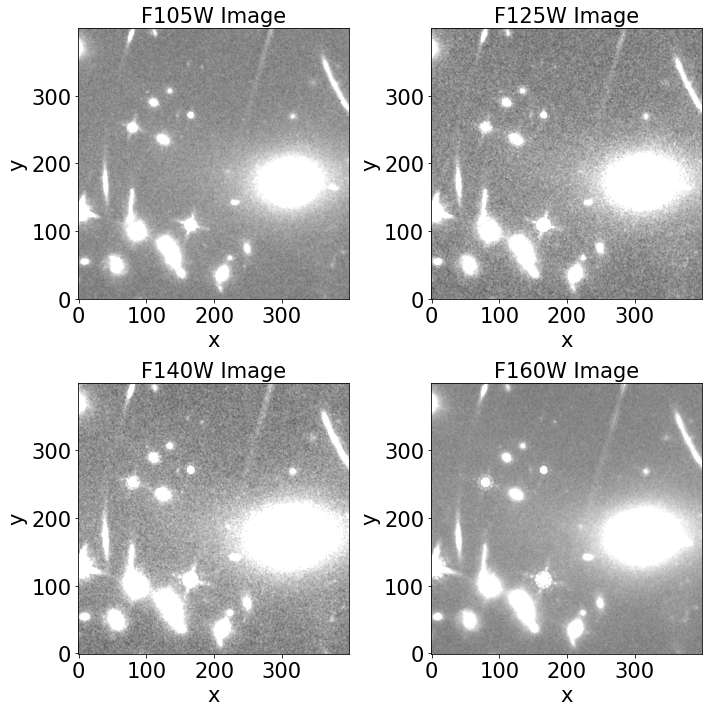

In [44]:
from astropy.nddata import Cutout2D
from astropy import units as u
cutoutposition = (2500, 2500)
cutoutsize = (400, 400)
hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F105W', 'F125W', 'F140W', 'F160W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

# Running Morpheus

In [45]:
classified = Classifier.classify(h=hcut, j=jcut, v=vcut, z=zcut)

# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(hcut, np.int)
mask[5:-5, 5:-5] = 1
segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)

catalog = Classifier.catalog_from_classified(classified, hcut, segmap)

rgb = Classifier.colorize_classified(classified)


classifying: 131batch [10:13,  4.69s/batch]                      
/tmp/ipykernel_20148/605678207.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 400/400 [00:00<00:00, 1388.68it/s]


# Colorizing Result

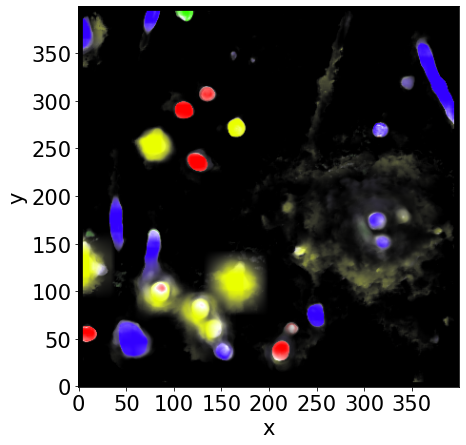

In [46]:
plt.figure(figsize=(7, 7))
plt.xlabel('x', fontsize=21)
plt.ylabel('y', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.imshow(rgb, origin='lower')
plt.show()

# Saving Result to Dataframe, CSV

In [48]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs import WCS

wcs = WCS(h_header)

morpheus_result = pd.DataFrame(catalog)
morpheus_result['ra'] = pd.Series(dtype='float')
morpheus_result['dec'] = pd.Series(dtype='float')
morpheus_result['x'] = pd.Series(dtype='float')
morpheus_result['y'] = pd.Series(dtype='float')
morpheus_result['p_sph'] = pd.Series(dtype='float')
morpheus_result['p_disk'] = pd.Series(dtype='float')
morpheus_result['p_irr'] = pd.Series(dtype='float')
morpheus_result['p_ps'] = pd.Series(dtype='float')

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['x'][i] = morpheus_result['location'][i][1]
    morpheus_result['y'][i] = morpheus_result['location'][i][0]
    morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
    morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
    morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
    morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
   
morpheus_result['real_x'] = morpheus_result['x']+(cutoutposition[0]-cutoutsize[0]/2)
morpheus_result['real_y'] = morpheus_result['y']+(cutoutposition[1]-cutoutsize[1]/2)

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
    morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree


/tmp/ipykernel_20148/2421671279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_20148/2421671279.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_20148/2421671279.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0

In [49]:
import os 
# os.makedirs("./output")
morpheus_result.to_csv("./morpheus_result.csv")

# Filtering High-Probabilithy Disk Candidates

In [50]:
datmor = pd.DataFrame(pd.read_csv("morpheus_result.csv"))
datmor_highdisk=datmor.loc[datmor['p_disk'] > 0.5]
datmor_highdisk

,Unnamed: 0,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
1,1,2,"[38, 152]","[0.13350952296411764, 0.7394473996827445, 0.05...",110.836241,-73.456886,152.0,38.0,0.133510,0.739447,0.051676,0.075367,2452.0,2338.0
2,2,3,"[47, 56]","[4.449912931686453e-06, 0.9711586056081335, 0....",110.841861,-73.456736,56.0,47.0,0.000004,0.971159,0.028812,0.000025,2356.0,2347.0
5,5,6,"[75, 249]","[0.0031394860949273315, 0.9855209561342493, 0....",110.830564,-73.456269,249.0,75.0,0.003139,0.985521,0.009156,0.002184,2549.0,2375.0
10,10,11,"[166, 41]","[2.831416647493969e-06, 0.9808198775880248, 0....",110.842737,-73.454752,41.0,166.0,0.000003,0.980820,0.018279,0.000898,2341.0,2466.0
11,11,12,"[152, 320]","[0.14826546583591302, 0.7726052666493453, 0.00...",110.826409,-73.454986,320.0,152.0,0.148265,0.772605,0.000918,0.078212,2620.0,2452.0
12,12,13,"[172, 313]","[0.14518250549341702, 0.796515884954872, 4.937...",110.826818,-73.454653,313.0,172.0,0.145183,0.796516,0.000005,0.058297,2613.0,2472.0
16,16,17,"[269, 317]","[0.21465392847822623, 0.770822205641764, 0.013...",110.826585,-73.453036,317.0,269.0,0.214654,0.770822,0.013815,0.000708,2617.0,2569.0
17,17,18,"[289, 392]","[0.00010299864016631229, 0.974810267896747, 0....",110.822196,-73.452702,392.0,289.0,0.000103,0.974810,0.024478,0.000609,2692.0,2589.0
20,20,21,"[369, 5]","[0.0005651646029873465, 0.9704477687665133, 0....",110.844842,-73.451369,5.0,369.0,0.000565,0.970448,0.023257,0.005730,2305.0,2669.0
21,21,22,"[392, 79]","[8.018094066012201e-05, 0.9662492872442597, 0....",110.840512,-73.450986,79.0,392.0,0.000080,0.966249,0.032958,0.000713,2379.0,2692.0


# Plotting detected sources on image and colormap

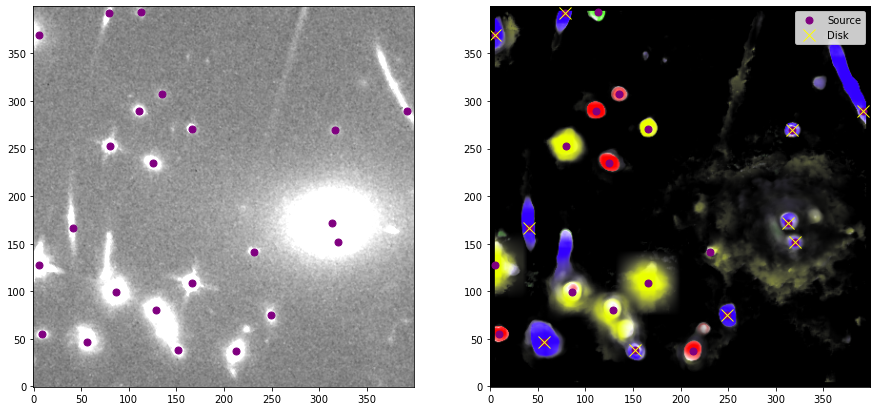

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
axs[0].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple')
axs[1].imshow(rgb, origin='lower')
axs[1].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple', label='Source')
axs[1].plot(datmor_highdisk['x'], datmor_highdisk['y'], 'x', ms=12, color='yellow', label='Disk')
axs[1].legend()


Red = Spheroid <br>
Blue = Disk <br>
Green = Irregular <br>
Yellow = Point Source (compact) <br>
Back = Background <br>
White = Can't Classify (two class prob is so similar) <br>